# 치매, 심근경색, 뇌혈관 질환 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

In [6]:
!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/36/a5/703d93321f57048596217789be7c186304a33aff5b1c48c89597a546c65e/xgboost-1.0.2.tar.gz
  Created wheel for xgboost: filename=xgboost-1.0.2-cp37-cp37m-macosx_10_9_x86_64.whl size=3416667 sha256=dac601469a1cd4efe94846de23d87227980221104bf694523b70392c29f898c3
  Stored in directory: /Users/proteo/Library/Caches/pip/wheels/2d/88/a6/eae5e2f880d228c2e8c057a2b166a05306f41e1ceaa2a01b45
Successfully built xgboost


In [8]:
# ## Modeling

from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn import metrics
from datetime import datetime


In [9]:
#### 함수 정의

def plot_confusion_metrixs(y_test, model_test, model_name):

    if showplot_flag == 1:
  
        cm = metrics.confusion_matrix(y_test, model_test, labels=[1, 0])
        plt.figure(1)
        plt.clf()
    #    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
        plt.imshow(cm)
        classNames = ['Heart disease','Normal']
        plt.title('Confusion Matrix of ' + model_name )
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        tick_marks = np.arange(len(classNames))
        plt.xticks(tick_marks, classNames)
        plt.yticks(tick_marks, classNames)
        s = [['TP','FN'], ['FP', 'TN']]
        for i in range(2):
            for j in range(2):
                plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
        plt.show()

def report_performance(model):

    y_pred = model.predict(X_test)
    model_name = str((str(model).split('=')[6])).split('(')[0]

    print('\n=== Modeling : {} '.format(model))
    print("=== model name : ", model_name)
    print('=== Accuracy Score : {}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('=== AUC Score : {}'.format(metrics.roc_auc_score(y_test, y_pred)))
 
    print("\nConfusion Matrix: ") # tn, fp, fn, tp
    print("{0}".format(metrics.confusion_matrix(y_test, y_pred, labels=[1, 0])))
    print("\nClassification Report: ")
    print(metrics.classification_report(y_test, y_pred))
    plot_confusion_metrixs(y_test, y_pred, model_name)

total_fpr = {}
total_tpr = {}

total_auc = {}
def roc_curves(model, seperator=False):

# get model name
    model_name = str((str(model).split('=')[6])).split('(')[0]

# 예측
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
# model 비교를 위하여 저장
    if seperator == False:
        total_fpr[str((str(model).split('(')[0]))] = fpr
        total_tpr[str((str(model).split('(')[0]))] = tpr
        total_auc[str((str(model).split('(')[0]))] = roc_auc
    else:
        model_name = str((str(model).split('=')[6]))
        model_name = str((str(model).split('=')[6])).split('(')[0]

        total_fpr[model_name] = fpr
        total_tpr[model_name] = tpr
        total_auc[model_name] = round(roc_auc, 3)
        
# ROC curve
    if showplot_flag == 1:
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve of ' + model_name)
        plt.legend(loc="lower right")
        plt.show()

total_accuracy = {}
def report_accuracy(model, seperator=False):
    y_pred = model.predict(X_test)
    accu = round(metrics.accuracy_score(y_test, y_pred), 3)
    print("\nAccuracy Of the Model({}): {} \n".format( model, accu))
    
    if seperator == False:
        total_accuracy[str((str(model).split('(')[0]))] = accu
    else:
        model_name = str((str(model).split('=')[6]))
        model_name = str((str(model).split('=')[6])).split('(')[0]

        total_accuracy[model_name] = accu

### 데이터 로드 및 설정

In [12]:
# ### 데이터 로드 및 설정
target_case_dic = {
                   1:'dementia',
                   2:'ischaemic heart',
                   3:'cerebrovascular',
                   4:'atrial_fibrillation'
                   }
# 예측하려는 대상 케이스 세팅 - 1 : 치매, 2 : 심근경색, 3 : 뇌혈관
target_case = 2  

# sampling 배수를 선택
sampling_unit = 1

# 대상이 되는 나이 그룹 - 7: 30-34세, 8: 35-39세, 9:40-44세, 10:45-49세, 11 : 50-55세, 12 : 55-59세, 13: 60-65세, 14 : 65-70세
target_agegroup = 11

# 건강검진 대상 집단 선택  - 1: 대상기간 전체, 2: 대상기간에 건강검진을 매번 받은 대상, 
target_group = 0        # 0: 주어진 기간 전체 데이타, 2: 주어진 기간 전체 데이터(주요 변수 년도별 )

showplot_flag = 0       # 1 : 중간 plot 보여줌
# merge_gender_flag = 1   # 0 : agegroup, gender를 나누어서 샘플링, 1 : gender 구분 없이 샘플링

sample_method = 1   # 0: age_group, gener를 고려하지 않고, 1 : age_group, gender 고려

cflag = 1 # no cflag

print("target case : {}, target agegroup : {}, sampling : {} ".format(target_case, target_agegroup, sampling_unit))

target case : 2, target agegroup : 11, sampling : 1 


In [13]:
# 분석대상 년도
target_year = '2013'  # 2013년

if target_group == 0 :
    if (target_case == 1):    # 치매
        input_filename = 'data/data_dementia_' + target_year + '.csv'
    elif (target_case == 2):  # 심근경색
        input_filename = 'data/data_ischaemic_heart_' + target_year + '.csv'
    elif (target_case == 3):  # 뇌혈관
        input_filename = 'data/data_cerebrovascular_' + target_year + '.csv'
    elif (target_case == 4):  # 심방세동
        input_filename = 'data/data_atrial_fibrillation_' + target_year + '.csv'
elif target_group == 2: 
    if (target_case == 1):    # 치매
        input_filename = 'data/data_dementia_diff_' + target_year + '.csv'
    elif (target_case == 2):  # 심근경색
        input_filename = 'data/data_ischaemic_heart_diff_' + target_year + '.csv'
    elif (target_case == 3):  # 뇌혈관
        input_filename = 'data/data_cerebrovascular_diff_' + target_year + '.csv'
    elif (target_case == 4):  # 심방세동
        input_filename = 'data/data_atrial_fibrillation_diff_' + target_year + '.csv'


print("input filename : ", input_filename)
print("cflag", cflag)

random_state_val = 13250 + cflag
print("random state :  ", random_state_val)

input filename :  data/data_ischaemic_heart_2013.csv
cflag 1
random state :   13251


In [14]:
print(input_filename)

data/data_ischaemic_heart_2013.csv


In [15]:
# 전체 데이터 로드
df = pd.read_csv(input_filename, header=0, index_col=0, encoding='utf-8')
print("total data : ", len(df))

total data :  234478


In [7]:
# 분류 항목의 분포를 확인 
group_count = df.groupby(['GROUP', 'SEX','AGE_GROUP']).size()
print("\n=== All target ===")
print(group_count)


=== All target ===
GROUP  SEX  AGE_GROUP
0.0    1    2                1
            4              306
            5             2228
            6             8273
            7            14889
            8            13363
            9            18612
            10           14431
            11           15986
            12           11707
            13            9003
            14            5803
            15            5419
            16            2153
            17             993
            18             250
       2    4              292
            5             3444
            6             7279
            7             7263
            8             5476
            9            15701
            10           12246
            11           16310
            12           11238
            13           10038
            14            5768
            15            6363
            16            2659
            17            1536
            18             4

In [16]:
# AGE_GROUP의 조건에 해당하는 mainsick 대상자 로드
df_mainsick = df[(df['GROUP'] == 1) ]
print("Total number of main sick : ", len(df_mainsick))

Total number of main sick :  4962


In [17]:
# AGE_GROUP의 조건에 해당하는 mainsick 대상자 로드
df_mainsick = df[(df['AGE_GROUP'] >= target_agegroup) & (df['GROUP'] == 1) ]
print("Target Age Group: ", target_agegroup, " Number of main sick :" , len(df_mainsick))

Target Age Group:  11  Number of main sick : 4451


In [18]:
# AGE_FROUP의 조건에 따른 mainsick가 0인 대상자
df_normal = df[(df['AGE_GROUP'] >= target_agegroup) & (df['GROUP'] == 0) ]
print("normal ", len(df_normal))

normal  105712


In [19]:
# df_sample에 maic_sick targer 데이터를 넣는다
df_sample = pd.DataFrame()
df_sample = pd.concat([df_sample, df_mainsick])

# target main_sick에 대상자에 대해서 male/female, age_group별 카운트를 얻는다
group_count = df_mainsick.groupby(['GROUP', 'SEX','AGE_GROUP']).size()
print("\n=== mainsick target ===")
print(group_count)

# 남자 연령별 숫자
agegroup_male = group_count[1][1]
agegroup_male = agegroup_male.reset_index(name='COUNT')
print("\n=== mail agegroup === \n{}".format(agegroup_male))
print("mail agegroup sum : {}".format(agegroup_male.sum()))

# 여자 연령별 숫자
agegroup_female = group_count[1][2]
agegroup_female = agegroup_female.reset_index(name='COUNT')
print("\n=== femail agegroup === \n{}".format(agegroup_female))
print("femail agegroup sum : {}".format(agegroup_female.sum()))

### - 타겟 상병의 남/여, 나이그룹의 숫자의 특정 배수에 해당하는 정상 데--이터를 샘플링
# - main_sick의 male/female, age_group의 숫자에 해당하는 일반 대상자를 뽑아냄
# df_sample에 maic_sick target 데이터를 넣는다

for gender in range(1, 3):     
    if gender == 1:
        agegroup_target = agegroup_male
    else :
        agegroup_target = agegroup_female
        
    for i in range(0, len(agegroup_target)  ):
        age_group, count = agegroup_target.iloc[i]
        #n배수 샘플링
        sampling_count = count * sampling_unit
        print(gender, age_group, count, sampling_count)
        df_temp = df[(df['GROUP'] == 0) & (df['AGE_GROUP'] == age_group) & (df['SEX'] == gender)].sample(n=sampling_count, random_state=1234)
        df_sample = pd.concat([df_sample, df_temp])



=== mainsick target ===
GROUP  SEX  AGE_GROUP
1.0    1    11           367
            12           430
            13           541
            14           446
            15           498
            16           223
            17            95
            18            16
       2    11           189
            12           228
            13           352
            14           284
            15           459
            16           188
            17           115
            18            20
dtype: int64

=== mail agegroup === 
   AGE_GROUP  COUNT
0         11    367
1         12    430
2         13    541
3         14    446
4         15    498
5         16    223
6         17     95
7         18     16
mail agegroup sum : AGE_GROUP     116
COUNT        2616
dtype: int64

=== femail agegroup === 
   AGE_GROUP  COUNT
0         11    189
1         12    228
2         13    352
3         14    284
4         15    459
5         16    188
6         17    115
7         18     

In [20]:
# ### 모델링을 위한 전처리 작업

df = df_sample.copy()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8902 entries, 28 to 12
Data columns (total 43 columns):
PERSON_ID                8902 non-null float64
YKIHO_GUBUN_CD           8902 non-null int64
HEIGHT                   8902 non-null float64
WEIGHT                   8902 non-null float64
WAIST                    8902 non-null float64
BP_HIGH                  8902 non-null float64
BP_LWST                  8902 non-null float64
BLDS                     8902 non-null float64
TOT_CHOLE                8902 non-null float64
TRIGLYCERIDE             8902 non-null float64
HDL_CHOLE                8902 non-null float64
LDL_CHOLE                8902 non-null float64
HMG                      8902 non-null float64
OLIG_PROTE_CD            8902 non-null float64
CREATININE               8902 non-null float64
SGOT_AST                 8902 non-null float64
SGPT_ALT                 8902 non-null float64
GAMMA_GTP                8902 non-null float64
HCHK_APOP_PMH_YN         8902 non-null float64
HCH

In [22]:
df.head()

,PERSON_ID,YKIHO_GUBUN_CD,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,...,CUR_SMK_TERM_RSPS_CD,CUR_DSQTY_RSPS_CD,DRNK_HABIT_RSPS_CD,TM1_DRKQTY_RSPS_CD,MOV20_WEK_FREQ_ID,MOV30_WEK_FREQ_ID,WLK30_WEK_FREQ_ID,GROUP,SEX,AGE_GROUP
28,70679072.0,28,156.0,50.0,80.0,130.0,80.0,128.0,173.0,155.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18
37,81120944.0,31,149.0,33.0,71.0,103.0,55.0,127.0,208.0,141.0,...,0.0,0.0,1.0,0.0,1.0,1.0,4.0,1.0,2,18
61,62033537.0,20,151.0,45.0,84.0,110.0,70.0,112.0,133.0,51.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1,18
62,92308600.0,20,140.0,46.0,89.0,140.0,100.0,118.0,180.0,146.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18
109,21928731.0,32,151.0,57.0,87.0,142.0,95.0,91.0,236.0,217.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18


#### train, test set 분리

In [23]:
# 모델링을 위한 데이터 셋을 저장
date_time = datetime.now().strftime("%Y%m%d_%H%M%S")
#result_train_filename = "data/train_test_data_" + target_case_dic.get(target_case) + "_" + date_time + ".csv"
result_train_filename = "data/train_test_data_" + target_case_dic.get(target_case) + "_" + target_year + "_" + date_time + ".csv"

print(result_train_filename)
#sys.exit()
df.to_csv(result_train_filename, encoding='utf-8')

data/train_test_data_ischaemic heart_2013_20200307_081548.csv


#### train_test data 를 바로 읽어서 처리할 경우

In [24]:
input_filename = result_train_filename
df = pd.read_csv(input_filename, header=0, index_col=0, encoding='utf-8')
print("train_test data : ", len(df))

train_test data :  8902


#### 허리둘레/신장 비율(waist-to-height ratio, WHtR)

In [25]:
df.head()

,PERSON_ID,YKIHO_GUBUN_CD,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,...,CUR_SMK_TERM_RSPS_CD,CUR_DSQTY_RSPS_CD,DRNK_HABIT_RSPS_CD,TM1_DRKQTY_RSPS_CD,MOV20_WEK_FREQ_ID,MOV30_WEK_FREQ_ID,WLK30_WEK_FREQ_ID,GROUP,SEX,AGE_GROUP
28,70679072.0,28,156.0,50.0,80.0,130.0,80.0,128.0,173.0,155.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18
37,81120944.0,31,149.0,33.0,71.0,103.0,55.0,127.0,208.0,141.0,...,0.0,0.0,1.0,0.0,1.0,1.0,4.0,1.0,2,18
61,62033537.0,20,151.0,45.0,84.0,110.0,70.0,112.0,133.0,51.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1,18
62,92308600.0,20,140.0,46.0,89.0,140.0,100.0,118.0,180.0,146.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18
109,21928731.0,32,151.0,57.0,87.0,142.0,95.0,91.0,236.0,217.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18


In [26]:
df['WHTR'] = df['WAIST']/df['HEIGHT']

In [27]:
df.head()

,PERSON_ID,YKIHO_GUBUN_CD,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,...,CUR_DSQTY_RSPS_CD,DRNK_HABIT_RSPS_CD,TM1_DRKQTY_RSPS_CD,MOV20_WEK_FREQ_ID,MOV30_WEK_FREQ_ID,WLK30_WEK_FREQ_ID,GROUP,SEX,AGE_GROUP,WHTR
28,70679072.0,28,156.0,50.0,80.0,130.0,80.0,128.0,173.0,155.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18,0.512821
37,81120944.0,31,149.0,33.0,71.0,103.0,55.0,127.0,208.0,141.0,...,0.0,1.0,0.0,1.0,1.0,4.0,1.0,2,18,0.476510
61,62033537.0,20,151.0,45.0,84.0,110.0,70.0,112.0,133.0,51.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1,18,0.556291
62,92308600.0,20,140.0,46.0,89.0,140.0,100.0,118.0,180.0,146.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18,0.635714
109,21928731.0,32,151.0,57.0,87.0,142.0,95.0,91.0,236.0,217.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18,0.576159


#### BMI 비만 계산 방법
- 신체질량지수인 BMI(Body Mass Index)에 근거한 방식
- BMI지수= 몸무게(kg) ÷ (신장(m) × 신장(m)) = [몸무게 (kg) / (신장 (cm) x 신장 (cm))] x 10000
- 산출된 값이 18.5 이하면 저체중, 18.5~23은 정상, 23~25는 과체중, 25~30은 비만, 30이상은 고도비만으로 나누어진다. 

In [28]:
df.head()

,PERSON_ID,YKIHO_GUBUN_CD,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,...,CUR_DSQTY_RSPS_CD,DRNK_HABIT_RSPS_CD,TM1_DRKQTY_RSPS_CD,MOV20_WEK_FREQ_ID,MOV30_WEK_FREQ_ID,WLK30_WEK_FREQ_ID,GROUP,SEX,AGE_GROUP,WHTR
28,70679072.0,28,156.0,50.0,80.0,130.0,80.0,128.0,173.0,155.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18,0.512821
37,81120944.0,31,149.0,33.0,71.0,103.0,55.0,127.0,208.0,141.0,...,0.0,1.0,0.0,1.0,1.0,4.0,1.0,2,18,0.476510
61,62033537.0,20,151.0,45.0,84.0,110.0,70.0,112.0,133.0,51.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1,18,0.556291
62,92308600.0,20,140.0,46.0,89.0,140.0,100.0,118.0,180.0,146.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18,0.635714
109,21928731.0,32,151.0,57.0,87.0,142.0,95.0,91.0,236.0,217.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2,18,0.576159


In [29]:
df['BMI'] = df['WEIGHT']/(df['HEIGHT']*df['HEIGHT']) * 10000

In [30]:
df.head()

,PERSON_ID,YKIHO_GUBUN_CD,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,...,DRNK_HABIT_RSPS_CD,TM1_DRKQTY_RSPS_CD,MOV20_WEK_FREQ_ID,MOV30_WEK_FREQ_ID,WLK30_WEK_FREQ_ID,GROUP,SEX,AGE_GROUP,WHTR,BMI
28,70679072.0,28,156.0,50.0,80.0,130.0,80.0,128.0,173.0,155.0,...,1.0,0.0,1.0,1.0,1.0,1.0,2,18,0.512821,20.545694
37,81120944.0,31,149.0,33.0,71.0,103.0,55.0,127.0,208.0,141.0,...,1.0,0.0,1.0,1.0,4.0,1.0,2,18,0.476510,14.864195
61,62033537.0,20,151.0,45.0,84.0,110.0,70.0,112.0,133.0,51.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1,18,0.556291,19.735976
62,92308600.0,20,140.0,46.0,89.0,140.0,100.0,118.0,180.0,146.0,...,1.0,0.0,1.0,1.0,1.0,1.0,2,18,0.635714,23.469388
109,21928731.0,32,151.0,57.0,87.0,142.0,95.0,91.0,236.0,217.0,...,1.0,0.0,1.0,1.0,1.0,1.0,2,18,0.576159,24.998904


#### Modeling을 위한 변수 선택

In [31]:
feature_col_names = [
# 성별    
                     'SEX',
# 연령 그룹
                     'AGE_GROUP', 
# 허리둘레
#                    'HEIGHT', 'WEIGHT',
#                    'WAIST',
# BMI
                    'BMI',
# WHTR
                    'WHTR',
# 혈압 수치                                           
                     'BP_HIGH', 'BP_LWST',  #수축기혈압, 이완기혈압, 
# 혈당 수치    
                     'BLDS', #식전혈당(공복혈당)
# 콜레스테롤 수치                         
                     'TOT_CHOLE', 'HDL_CHOLE','LDL_CHOLE',                      
# 중성 지방 수치    
                     'TRIGLYCERIDE', 
# 혈색소
                     'HMG',
# 요단백                      
                     'OLIG_PROTE_CD',
# 혈청 
                    'CREATININE', 'SGOT_AST', 'SGPT_ALT', 'GAMMA_GTP',
# 본인 과거 병력
                     'HCHK_APOP_PMH_YN',  # (본인)뇌졸중과거병력유무
                     'HCHK_HDISE_PMH_YN',  # (본인)심장병과거병력유무
                     'HCHK_HPRTS_PMH_YN', # (본인)고혈압과거병력유무
                     'HCHK_DIABML_PMH_YN', # (본인)당뇨병과거병력유무
                     'HCHK_HPLPDM_PMH_YN', # (본인)고지혈증(이상지질혈증)과거병력유무
                     'HCHK_PHSS_PMH_YN',   # (본인)폐결핵과거병력유무, 2010년부터 적용
                     'HCHK_ETCDSE_PMH_YN', # (본인)기타(암포함)질환과거병력유무
# 가족 과거 병력
                     'FMLY_APOP_PATIEN_YN',
                     'FMLY_HDISE_PATIEN_YN', 
                        'FMLY_HPRTS_PATIEN_YN',
                        'FMLY_DIABML_PATIEN_YN',
                        'FMLY_CANCER_PATIEN_YN', 

# 흡연 상태
                     'PAST_SMK_TERM_RSPS_CD', #(과거)흡연기간
                     'PAST_DSQTY_RSPS_CD', # (과거)하루흡연량
                     'CUR_SMK_TERM_RSPS_CD', # (현재)흡연기간
                     'CUR_DSQTY_RSPS_CD', # (현재)하루흡연량
    
# 음주 상태                     
                     'DRNK_HABIT_RSPS_CD', #음주습관
                     'TM1_DRKQTY_RSPS_CD', # 1회 음주량
# 운동 상태                     
                      'MOV20_WEK_FREQ_ID', #1주_20분이상 격렬한 운동
                      'MOV30_WEK_FREQ_ID', #1주_30분이상 중간정도 운동
                      'WLK30_WEK_FREQ_ID', #1주_총30분이상 걷기 운동
                    ]

predicted_class_names = ['GROUP']

X = df[feature_col_names].values
y = df[predicted_class_names].values

In [32]:
# train, test set 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123456)
print("total count : {}, df_train count : {}, df_test count : {}".format(len(df), len(X_train), len(X_test)))

print(X_train.shape)
print(X_test.shape)

total count : 8902, df_train count : 6231, df_test count : 2671
(6231, 38)
(2671, 38)


In [33]:
# ### - minmaxscale, stardardscale

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 데이터 표준화 작업
standardScaler = StandardScaler()
X_train = standardScaler.fit_transform(X_train)
X_test = standardScaler.fit_transform(X_test)

#### 주요 인자 중요도를 보기위해 랜덤 포레스트 모델을 기준으로 삼아 비교 진행

In [34]:
# Feature Selection
rfc = RandomForestClassifier(criterion='gini',n_estimators=90, n_jobs=-1, max_features='auto', max_depth=10, random_state=123456)

# Fit model with training data
rfc.fit(X_train, y_train)

y_test_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)

print('\n=== Modeling : RandomForestClassfier ===')
print('Accuracy Score : {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('AUC Score : {}'.format(metrics.roc_auc_score(y_test, y_test_pred)))
print('<Confusion Matrix>')
print(metrics.confusion_matrix(y_test, y_test_pred, labels=[1, 0]))
print('<Classiffication Report>')
print(metrics.classification_report(y_test, y_test_pred))
print('<f1 score>')
print(metrics.f1_score(y_test, y_test_pred))

# ROC curve and Area-Under-Curve (AUC)


=== Modeling : RandomForestClassfier ===
Accuracy Score : 0.7472856608011981
AUC Score : 0.752237620539072
<Confusion Matrix>
[[ 833  547]
 [ 128 1163]]
<Classiffication Report>
              precision    recall  f1-score   support

         0.0       0.68      0.90      0.78      1291
         1.0       0.87      0.60      0.71      1380

    accuracy                           0.75      2671
   macro avg       0.77      0.75      0.74      2671
weighted avg       0.78      0.75      0.74      2671

<f1 score>
0.7116616830414353


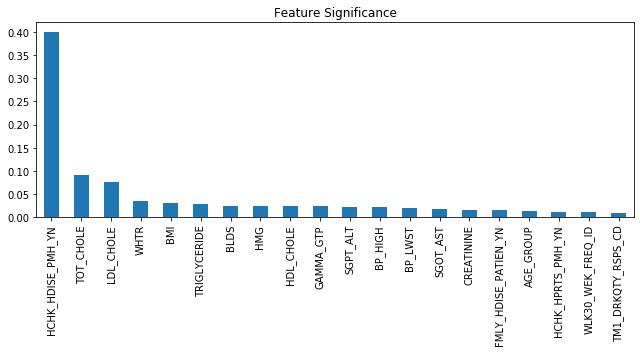

In [35]:
# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(rfc.feature_importances_, index = feature_col_names).sort_values(ascending=False)

plt.figure(figsize=(9, 5))
coef.head(20).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()
plt.show()

#### Modeling : 다양한 모델에 대해서 테스트를 진행 /w GridSearchCV

In [36]:
models = []
params = []

In [37]:
model = ('LogisticRegression', LogisticRegression())
param = {
        'penalty' : ['l2'],
        'solver' : ['lbfgs'],
        'C' : [0.1, 1, 10, 1e2, 1e3]      
}
models.append(model)
params.append(param)

model = ('RandomForest', RandomForestClassifier())
param = {
    'n_estimators':[20, 50, 70, 90, 100],
    'max_features': ['auto'],
    'max_depth' : [4,  6,  8, 10],
    'criterion' :['gini']
}

models.append(model)
params.append(param)

model = ('XGBoost', XGBClassifier())
param = {
    'max_depth' :[2, 5, 8 ],
    'n_estimators' :[20, 40, 50, 100],
    'learning_rate': [0.01, 0.05, 0.075, 0.1],
    'subsample' : [0.7, 0.8]
}

models.append(model)
params.append(param)


model = ('k-NN', KNeighborsClassifier())
param = {'n_neighbors': [4, 10, 20, 40, 60],
         'weights': ['uniform','distance']}

# k-NN은 대상 표본이 일정 정도 된 경우만 이 모델을 사용
if len(df) >= 100 :
    models.append(model)
    params.append(param)

model = ('DecisionTree', DecisionTreeClassifier())
param = {
    'max_depth' :[3, 4, 5, 7, 9, 11, 15, 20],
    'criterion':['gini','entropy']

}
models.append(model)
params.append(param)

model = ('ExtraTree', ExtraTreesClassifier())
param = {
        'n_estimators':[20, 50, 100],
        'max_features' : ['auto', 'sqrt','log2']
}
models.append(model)
params.append(param)

model = ('GradientBoosting', GradientBoostingClassifier())
param = {
        'n_estimators':[20, 50, 100],
        'learning_rate': [0.01, 0.075, 0.2],
#        'max_features' : [2, 4, 6, 8],
        'max_features' : [2, 4, 6],
        'max_depth' :[2, 5, 8]
}
models.append(model)
params.append(param)

model = ('AdaBoost', AdaBoostClassifier())
param = {
        'n_estimators':[20, 50, 100],
        'learning_rate': [0.01, 0.075, 0.2],
}

models.append(model)
params.append(param)

model = ('SVC', SVC())
param = {
    'kernel' : ['linear', 'rbf'],
    'C':[0.1, 1, 10],
    'gamma': [0.1, 1, 10]
}

models.append(model)
params.append(param)

model = ('NeuralNetwork', MLPClassifier())
param = {
    # 'activation': ['logistic', 'tanh', 'relu'],
    # 'hidden_layer_sizes': [(9,), (9, 9)],
    # 'learning_rate_init': [0.005, 0.001]

    'hidden_layer_sizes': [(50,), (50,50)],
    'activation': ['logistic', 'tanh', 'relu'],
#    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.005, 0.001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
models.append(model)
params.append(param)


In [38]:
def gridsearch_cv_for_classifier(model, param, kfold, train_input, train_target, scoring='accuracy', n_jobs=-1, tracking=True):
    '''
    [Parameters]
    - model: A tuple like ('name', MODEL)
    - param
    - scoring: neg_mean_absolute_error, neg_mean_squared_error, neg_median_absolute_error, r2
               (http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
    - n_jobs: default as -1 (if it is -1, all CPU cores are used to train and validate models)
    - tracking: whether trained model's name and duration time are printed
    '''
    
    name = model[0]
    estimator = model[1]
    if tracking:
        start_time = datetime.now()
        print("[%s] Start parameter search for model '%s'" % (start_time, name))
        gridsearch = GridSearchCV(estimator=estimator, param_grid=param, cv=kfold, scoring=scoring, n_jobs=n_jobs)
        gridsearch.fit(train_input, train_target.ravel())
        end_time = datetime.now()
        duration_time = (end_time - start_time).seconds
        print("[%s] Finish parameter search for model '%s' (time: %d seconds)" % (end_time, name, duration_time))
        print()
    else:
        gridsearch = GridSearchCV(estimator=estimator, param_grid=param, cv=kfold, scoring=scoring, n_jobs=n_jobs)
        gridsearch.fit(train_input, train_target.ravel())
    
    return gridsearch

In [39]:
kfold = KFold(n_splits=4, shuffle=True, random_state=1234)

In [40]:
results = []
for i in range(len(models)):
    model = models[i]
    param = params[i]
    print(model)
    result = gridsearch_cv_for_classifier(model=model, param=param, kfold=kfold, train_input=X_train, train_target=y_train, scoring='roc_auc')
    print("=== train : best params ===")
    print(result.best_params_)
    print("=== train : best score : roc_auc ===")
    print(result.best_score_)
    print("\n")
    results.append(result)

('LogisticRegression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False))
[2020-03-07 08:16:50.303432] Start parameter search for model 'LogisticRegression'
[2020-03-07 08:16:53.043217] Finish parameter search for model 'LogisticRegression' (time: 2 seconds)

=== train : best params ===
{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
=== train : best score : roc_auc ===
0.8103144246388244


('RandomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                   

In [42]:
for row in results:
        print(row)

GridSearchCV(cv=KFold(n_splits=4, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100.0, 1000.0], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)
GridSearchCV(cv=KFold(n_splits=4, rando

In [44]:
for i in range(len(results)):
    report_performance(results[i]) 
    roc_curves(results[i], True)
    report_accuracy(results[i], True) 


=== Modeling : GridSearchCV(cv=KFold(n_splits=4, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100.0, 1000.0], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0) 
=== model name :  Logi


=== Modeling : GridSearchCV(cv=KFold(n_splits=4, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [4, 10, 20, 40, 60],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0) 
=== model name :  KNeighborsClassifier
=== Accuracy Score : 0.7248221639835267
=== AUC Score : 0.7305234679329584

Confusion Matrix: 
[[ 772  608]
 [ 127 1164]]

Classification Report: 
              precision    recall  f1-score   support

     


=== Modeling : GridSearchCV(cv=KFold(n_splits=4, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0) 
=== model name :  SVC
=== Accuracy Score : 0.7349307375514789
=== AUC Score : 0.7370589589016491

Confusion Matrix: 
[[ 929  451]
 [ 257 1034]]

Classification Report: 
              precision    recall  f1-score   support

      

#### Model Comparision

In [45]:
# ###  Accuracy : text
sorted_total_accuracy= sorted(total_accuracy.items(), key=lambda x: x[1], reverse=True)
sorted_total_accuracy
print(sorted_total_accuracy)
print('\n')

[('RandomForestClassifier', 0.75), ('ExtraTreesClassifier', 0.748), ('GradientBoostingClassifier', 0.748), ('XGBClassifier', 0.746), ('MLPClassifier', 0.746), ('DecisionTreeClassifier', 0.745), ('AdaBoostClassifier', 0.741), ('LogisticRegression', 0.736), ('SVC', 0.735), ('KNeighborsClassifier', 0.725)]




In [46]:
# ### ROC AUC text
sorted_total_auc= sorted(total_auc.items(), key=lambda x: x[1], reverse=True)
print(sorted_total_auc)

[('RandomForestClassifier', 0.755), ('ExtraTreesClassifier', 0.753), ('GradientBoostingClassifier', 0.753), ('XGBClassifier', 0.751), ('MLPClassifier', 0.751), ('DecisionTreeClassifier', 0.75), ('AdaBoostClassifier', 0.747), ('LogisticRegression', 0.742), ('SVC', 0.737), ('KNeighborsClassifier', 0.731)]


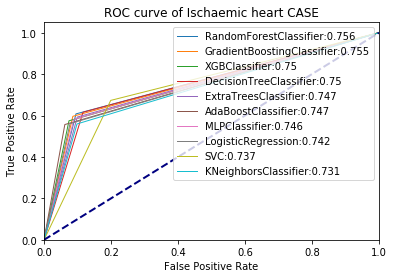

In [39]:
# ### ROC  AUC chart

sorted_total_auc = dict( sorted_total_auc)
for i in sorted_total_auc.keys():
    label_desc = i + ":" + str(total_auc[i])
    plt.plot(total_fpr[i],total_tpr[i],lw=1, label=label_desc )

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of ' + target_case_dic.get(target_case).capitalize() + ' CASE')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.show()